Import the Neccesary Libraries

In [ ]:
# Import the neccesary libraries needed
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler 
import numpy as np
from numpy import insert
import os
import time

# keras tuner for hyperparameter tuning
import keras_tuner as kt

# tensorflow Libraries
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import sparse_categorical_crossentropy
from keras.callbacks import EarlyStopping
from keras.models import load_model

Import the CSV Training and Testing Data Sets

In [ ]:
# Import the csv's (IMPORTANT: You need at least 16 Gb of RAM to proceed)
train=pd.read_csv(r'C:\Users\Daniel\OneDrive - University of Massachusetts Dartmouth\ECE457_Senior_Design_ECE5\CSV_Files\PortTraining_1404_002_FINAL.csv')
test=pd.read_csv(r'C:\Users\Daniel\OneDrive - University of Massachusetts Dartmouth\ECE457_Senior_Design_ECE5\CSV_Files\StbdTesting_1404_002_FINAL.csv')

In [ ]:
train[0:18]

Here I am going to remove the samp num 5 through 17 from each ping in the training dataset

In [ ]:
train.iloc[0,1]

In [ ]:
test

Split up the Features and Labels from both the Training and Testing Datasets

In [ ]:
# Split up the features and labels from both the training and testing datasets
x_train=train.iloc[:,4:24]
#x_train['TWTT']=train.iloc[:,28]  I feel as though the TWTT has NO impact on the DOA so we should NOT include it in training
x_train['Amplitude']=train.iloc[:,29]


x_test=test.iloc[:,4:24]
#x_test['TWTT']=test.iloc[:,28] I feel as though the TWTT has NO impact on the DOA so we should NOT include it in training
x_test['Amplitude']=test.iloc[:,29]

y_train=train.iloc[:,26]

y_test=test.iloc[:,26]

In [ ]:
y_test

In [ ]:
x_train

Scale the Feaures from -1 to 1 so that Training is Easier for the Model

In [ ]:
# Scale the Features and Labels from [-1,1]
s1=MinMaxScaler(feature_range=(-1,1))
x_train_scale=s1.fit_transform(x_train)

s2=MinMaxScaler(feature_range=(-1,1))
x_test_scale=s2.fit_transform(x_test)
x_test_scale=x_test_scale

# Scale DOA's from (0 to 1)
s3=MinMaxScaler(feature_range=(0,1))
#y_train_scale = s3.fit_transform(train[['DOA']])
y_train_scale= y_train.to_numpy()

s4=MinMaxScaler(feature_range=(0,1))
#y_test_scale = s4.fit_transform(test[['DOA']])
y_test_scale= y_test.to_numpy()

print(len(x_train_scale))
print(len(y_train_scale))

In [ ]:
Test_DOA_df= pd.DataFrame(y_test_scale, columns=['TEST DOAs'])
Test_DOA_df


In [ ]:
Test_DOA_df.describe()

In [ ]:
df= pd.DataFrame(x_train_scale, columns= ['I1', 'Q1', 'I2', 'Q2', 'I3', 'Q3', 'I4', 'Q4', 'I5', 'Q5', 'I6', 'Q6', 'I7', 'Q7', 'I8', 'Q8', 'I9', 'Q9', 'I10', 'Q10', 'Amplitude'])
df


In [ ]:
df.describe()

Shift the DOA's to the Left by one so that the Current I and Q data Align with the current DOA while using TimeSeriesGenerator to Window the Data

In [ ]:
# Shift the DOA to the left by one to use the current DOA label with the current I and Q data.
# Normally the TimeseriesGenerator function uses past values to predict the future but we would like current data to help predict the current samples' DOA
print(len(x_train_scale))
print(len(y_test_scale))
y_train_scale=insert(y_train_scale, 0, 0)
y_train_scale=np.delete(y_train_scale, -1)
y_test_scale=insert(y_test_scale, 0,0)
y_test_scale=np.delete(y_test_scale, -1)
print(y_train_scale)
print(len(y_train_scale))
print(y_test_scale)
print(len(y_test_scale))

Create the Windows Neccesary for the LSTM model using the TimeSeriesGenerator Function

In [ ]:
# Create the windows neccesary for the LSTM model within tensorflow keras
# Below are the arguments of the timeseries_dataset_from_array function
# The function takes a numpy array and makes a timeseries out of it
NumSampsPerPing= 4297
data=x_train_scale # the data to make the windows
targets=y_train_scale # time steps in the data (don't need)
sequence_length=10 # window length
sequence_stride=1# period between successive output sequences
sampling_rate=1 # period between successive individual timesteps     within sequences
batch_size=1 # number of time series samples in each batch
shuffle=False #shuffle the data before making the windows
seed=None # is related to shuffle
start_index=None # is related to shuffle
end_index=None # is related to shuffle
n_features=21

test_data=x_test_scale
test_targets=y_test_scale

inputs=TimeseriesGenerator(data, targets,sequence_length, batch_size)
#test_inputs=TimeseriesGenerator(test_data[0:40000], -1*test_targets[0:40000],sequence_length, batch_size)
test_inputs=TimeseriesGenerator(test_data, test_targets,sequence_length, batch_size)

#inputs=tf.keras.preprocessing.timeseries_dataset_from_array(data, targets, sequence_length, sequence_stride, sampling_rate, batch_size, shuffle)
#print(type(inputs))

print('done')

In [ ]:
# print the first couple of samples to see if everything everything is lining up
for i in range(100):
	x, y = inputs[i]
	print('%s => %s' % (x, y))

In [ ]:
# print the first couple of samples to see if everything everything is lining up
for i in range(100):
	x, y = test_inputs[i]
	print('%s => %s' % (x, y))

Define the Model's Structure

In [67]:
# With all the preproccessing done, it is time to define the model
# Define the LSTM Model
model= Sequential()
model.add(LSTM(units=64, activation='tanh', input_shape=(sequence_length,n_features), return_sequences=True, name='LSTM1'))
model.add(Dense(units=100))
model.add(Dropout(0.2))

model.add(LSTM(units=416, activation='tanh', return_sequences=True,name='LSTM2'))
model.add(Dense(units=100))
model.add(Dropout(0.2))

model.add(LSTM(units=512,name='LSTM3'))
model.add(Dense(units=100))
model.add(Dropout(0.2))

#model.add(LSTM(units=320, activation='tanh', return_sequences=True,name='LSTM4'))
#model.add(Dense(units=100))
#model.add(Dropout(0.2))

#model.add(LSTM(units=480))
#model.add(Dense(units=100))
#model.add(Dropout(0.2))


model.add(Dense(units=1)) #one output (namely: DOA)


In [55]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM1 (LSTM)                (None, 10, 64)            22016     
                                                                 
 dropout_16 (Dropout)        (None, 10, 64)            0         
                                                                 
 LSTM2 (LSTM)                (None, 10, 416)           800384    
                                                                 
 dropout_17 (Dropout)        (None, 10, 416)           0         
                                                                 
 LSTM3 (LSTM)                (None, 512)               1902592   
                                                                 
 dropout_18 (Dropout)        (None, 512)               0         
                                                                 
 dense_23 (Dense)            (None, 1)               

In [68]:
def scheduler(epoch,lr):
    if epoch>=1:
        return lr
    elif epoch>=2 | epoch<=4:
        return lr/1.75
    else:
        return lr*tf.math.exp(-.6)

Train the Model using the Specified Hyperparmeters

Epoch 1/10
4000/4000 [==============================] - 68s 16ms/step - loss: 345.4377 - lr: 5.4881e-05
Epoch 2/10
4000/4000 [==============================] - 63s 16ms/step - loss: 236.2673 - lr: 5.4881e-05
Epoch 3/10
4000/4000 [==============================] - 63s 16ms/step - loss: 218.3080 - lr: 5.4881e-05
Epoch 4/10
4000/4000 [==============================] - 63s 16ms/step - loss: 206.4913 - lr: 5.4881e-05
Epoch 5/10
4000/4000 [==============================] - 61s 15ms/step - loss: 194.7887 - lr: 5.4881e-05
Epoch 6/10
4000/4000 [==============================] - 61s 15ms/step - loss: 178.1353 - lr: 5.4881e-05
Epoch 7/10
4000/4000 [==============================] - 60s 15ms/step - loss: 158.8537 - lr: 5.4881e-05
Epoch 8/10
4000/4000 [==============================] - 58s 15ms/step - loss: 155.9767 - lr: 5.4881e-05
Epoch 9/10
4000/4000 [==============================] - 58s 15ms/step - loss: 149.8682 - lr: 5.4881e-05
Epoch 10/10
4000/4000 [==============================] - 62s 16m

Text(0, 0.5, 'loss')

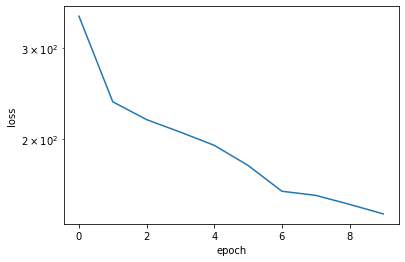

In [69]:
#Now it is time to train the model
opt=tf.keras.optimizers.Adam(learning_rate=0.0001)#,decay=1e-5)
model.compile(loss='mse', optimizer=opt)

# Allow for early stopping so that the model does not overfit the training dataset
#es= EarlyStopping(monitor='loss', mode='min',verbose=1,patience=10)

callback=tf.keras.callbacks.LearningRateScheduler(scheduler)

t0=time.time()
history= model.fit(inputs,epochs=10,steps_per_epoch=4000,batch_size=None,verbose=1, callbacks=[callback])
#history= model.fit(inputs)
t1=time.time()
print("The total run time to train was %.2f seconds"%(t1-t0))

# plot the loss function
plt.figure()
plt.semilogy(history.history['loss'])
plt.xlabel('epoch'); plt.ylabel('loss')


Reshape the Testing DataSet so that it Matches with what our Model Expects. THIS IS JUNK. DON'T USE THIS!!!!!!!!!!!!!!!!

In [ ]:
Validation_Data= x_test.to_numpy()
Validation_Data=Validation_Data.reshape((len(x_test), 1, 21))

Validation_Data.shape

Using the Model, Predict the DOA's on the Testing Dataset

In [70]:
#use the model to predict on the testing dataset
#for right now test_inputs has only the 40,001 samples
predicted=model.predict(test_inputs, verbose=1)

42814/42814 [==============================] - 272s 6ms/step


In [71]:
print(predicted[0:21])

[[71.32929 ]
 [67.12424 ]
 [67.7919  ]
 [67.78292 ]
 [67.38256 ]
 [69.21897 ]
 [69.49078 ]
 [69.79402 ]
 [72.45678 ]
 [76.8176  ]
 [77.73621 ]
 [77.226776]
 [76.64129 ]
 [78.08653 ]
 [78.39627 ]
 [77.821075]
 [78.828026]
 [78.91395 ]
 [78.58093 ]
 [78.83666 ]
 [79.22677 ]]


In [72]:
print(y_test[10:21])

10    75.344998
11    49.974999
12    50.274999
13    62.839999
14    61.619999
15    75.429998
16    76.294998
17    62.244999
18    57.394999
19    59.214999
20    61.579999
Name: DOA, dtype: float64


In [ ]:
type(predicted)
predicted.shape

In [ ]:
predicted_reshape= predicted.reshape(len(predicted),1)

In [ ]:
## JUNK 1st 10 SAMPLES ARE JUNK ANYWAYS DON'T USE

plt.figure(facecolor='white')
plt.plot(-y_test[20:30], '.')
plt.plot(predicted[20:30], '.')
plt.title("Actual")
plt.legend(['Actual','Predicted'])
plt.xlabel('Samples')
plt.ylabel('DOA in degrees')
plt.show()

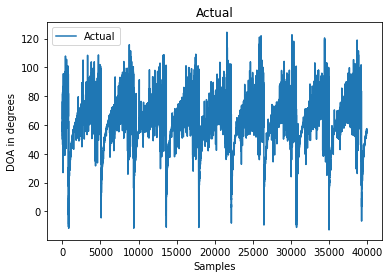

In [73]:
plt.figure(facecolor='white')
plt.plot(y_test[0:40000])
plt.title("Actual")
plt.xlabel('Samples')
plt.ylabel('DOA in degrees')
plt.legend(['Actual'])
plt.show()


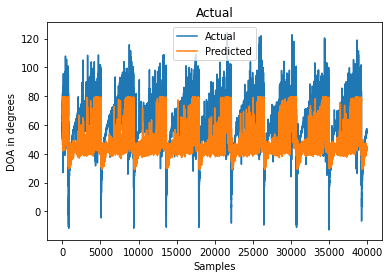

In [74]:
plt.figure(facecolor='white')
plt.plot(y_test[0:40000])
plt.plot(predicted[0:40000])
plt.title("Actual")
plt.xlabel('Samples')
plt.ylabel('DOA in degrees')
plt.legend(['Actual','Predicted'])
plt.show()



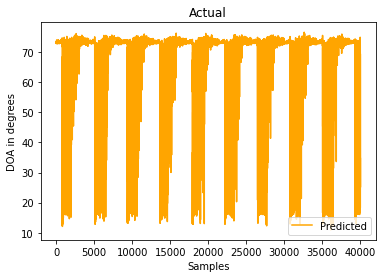

In [64]:
plt.figure(facecolor='white')
plt.plot(predicted[0:40000], 'orange')
plt.title("Actual")
plt.xlabel('Samples')
plt.ylabel('DOA in degrees')
plt.legend(['Predicted'])
plt.show()

Compare the Actual Testing DOA's to the Predicted DOA's

In [ ]:
plt.rcParams.update(plt.rcParamsDefault)


plt.figure(facecolor='white')
plt.plot(y_test[0:10], '.')
plt.plot(predicted[0:10], '.')
plt.title("Actual")
plt.legend(['Actual','Predicted'])
plt.xlabel('Samples')
plt.ylabel('DOA in degrees')
plt.show()

plt.figure(facecolor='white')
plt.plot(y_test[0:40000])
plt.plot(predicted_reshape[0:40000])
plt.title("Actual")
plt.xlabel('Samples')
plt.ylabel('DOA in degrees')
plt.legend(['Actual','Predicted'])
plt.show()


plt.figure(facecolor='white')
plt.plot(y_test[0:40000])
plt.title("Actual")
plt.xlabel('Samples')
plt.ylabel('DOA in degrees')
plt.legend(['Actual'])
plt.show()


plt.figure(facecolor='white')
plt.plot(predicted_reshape[0:40000], 'orange')
plt.title("Actual")
plt.xlabel('Samples')
plt.ylabel('DOA in degrees')
plt.legend(['Predicted'])
plt.show()


In [ ]:
print(y_test[0:50000])


In [ ]:
df2= pd.DataFrame(predicted, columns= ['DOA'])
df2

EVERYTHING BELOW HERE IS MY KERAS TUNER STUFF. VIEWER REGRESSION IS ADVISED.

In [ ]:
LOG_DIR = f"{int(time.time())}"

In [ ]:
def model_builder(hp):
    model= Sequential()

    #try
    hp_units_1 = hp.Int('units1', min_value=32, max_value=512, step=32)
    model.add(LSTM(units=hp_units_1, activation='tanh', input_shape=(sequence_length,n_features), return_sequences=True))
    model.add(Dropout(0.2))

    for i in range(hp.Int("n_layers",1,2)):
        model.add(LSTM(units=hp.Int(f"LSTM_{i}_units", min_value=32, max_value=512, step=32), activation='tanh', input_shape=(sequence_length,n_features), return_sequences=True))
        model.add(Dropout(0.2))

    #hp_units_2 = hp.Int('units2', min_value=32, max_value=512, step=32)
    #model.add(LSTM(units=hp_units_2, activation='relu',  return_sequences=True))
    #model.add(Dropout(0.2))

    #hp_units_3 = hp.Int('units3', min_value=32, max_value=512, step=32)
    #model.add(LSTM(units=hp_units_3, activation='relu', return_sequences=True))
    #model.add(Dropout(0.2))

    #hp_units_4 = hp.Int('units4', min_value=32, max_value=512, step=32)
    #model.add(LSTM(units=hp_units_4, activation='relu',  return_sequences=True))
    #model.add(Dropout(0.2))

    model.add(Dense(units=1)) #one output (namely: DOA)

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    opt=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate,decay=1e-5)
    model.compile(loss='mse', optimizer=opt)

    return model

In [ ]:
es= EarlyStopping(monitor='loss', mode='min',verbose=1,patience=10)

tuner = kt.RandomSearch(model_builder, objective='loss', max_trials=1000, directory=os.path.normpath('C:/'))
tuner.search(inputs,steps_per_epoch=2000,epochs=20,verbose=1, callbacks=[es])

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]


print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units1')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}. 
""")

In [ ]:
print(f"""
Unit1: {best_hps.get('units1')} learning rate {best_hps.get('learning_rate')} LSTM0 units: {best_hps.get('LSTM_0_units')} LSTM1 units: {best_hps.get('LSTM_1_units')} 
""")

Put the predicted DOA's back into a csv file format

In [48]:
#Ping |  Num Samp Num | PORT or STBD (0 or 1) |  TWTT |  Predicted DOA   <=======Output columns.
OutputCSVdf=test.iloc[:,[0,1,2,3]]
#OutputCSVdf= pd.DataFrame(test.iloc[:,[0,1,2,3]], columns=['PingNumber','SampNumber','PortStbd', 'SampleTime'])
zerosArray= np.arange(sequence_length)*0
predictedShifted=np.append(zerosArray, predicted)
Predicteddf= pd.DataFrame(predictedShifted,columns=['PredictedDOA'])
OutputCSVdf=OutputCSVdf.join(Predicteddf)

In [49]:
test.iloc[:,[0,1,2,3]]

,PingNum,SampleNum,PortStbd,SampleTimeDelay
0,87443,24,1,0.000353
1,87443,25,1,0.000369
2,87443,26,1,0.000384
3,87443,27,1,0.000399
4,87443,28,1,0.000415
...,...,...,...,...
5480113,88723,4297,1,0.065982
5480114,88723,4298,1,0.065998
5480115,88723,4299,1,0.066013
5480116,88723,4300,1,0.066028


In [50]:
zerosArray= np.arange(sequence_length)*0
zerosArray

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [51]:
predictedShifted=np.append(zerosArray, predicted)
predictedShifted

array([ 0.        ,  0.        ,  0.        , ..., 55.48680496,
       61.87079239, 66.98963165])

In [52]:
OutputCSVdf

,PingNum,SampleNum,PortStbd,SampleTimeDelay,PredictedDOA
0,87443,24,1,0.000353,0.000000
1,87443,25,1,0.000369,0.000000
2,87443,26,1,0.000384,0.000000
3,87443,27,1,0.000399,0.000000
4,87443,28,1,0.000415,0.000000
...,...,...,...,...,...
5480113,88723,4297,1,0.065982,40.969475
5480114,88723,4298,1,0.065998,46.567200
5480115,88723,4299,1,0.066013,55.486805
5480116,88723,4300,1,0.066028,61.870792


In [53]:
OutputCSVdf.to_csv(path_or_buf="C:\\Users\\Daniel\\OneDrive - University of Massachusetts Dartmouth\\ECE457_Senior_Design_ECE5\\AIOutput_CSV_Files\\PredictedOutputTest3.csv")